In [1]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

import logging
import time
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'
train_csv_path = '/content/drive/MyDrive/boilers_drive/train_df.csv'
val_csv_path = '/content/drive/MyDrive/boilers_drive/val_df.csv'
test_csv_path = '/content/drive/MyDrive/boilers_drive/test_df.csv'

Mounted at /content/drive


In [3]:
# Specify the file path of your CSV file

# Read the CSV file
train_data = pd.read_csv(train_csv_path)
val_data = pd.read_csv(val_csv_path)
test_data = pd.read_csv(test_csv_path)

In [4]:
#print(train_data)
#print(val_data)
#print(test_data)

In [5]:
# load pre-prepared random order of houses

random_order_houses = pd.read_csv('/content/drive/MyDrive/boilers_drive/random_order_houses.csv')

In [6]:
# Different houses in data
houses = random_order_houses['house_id'].unique().tolist()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home9', 'home114', 'home5', 'home89', 'home17', 'home63', 'home2', 'home101', 'home14', 'home95', 'home111', 'home67', 'home77', 'home43', 'home86', 'home90', 'home47', 'home110', 'home93', 'home53', 'home34', 'home51', 'home106', 'home46', 'home79', 'home55', 'home65', 'home13']
Number of different houses:
28


In [7]:
#house_datasets = {}
#for house in houses:
#    house_datasets[house] = data[data['house_id'] == house]

#print(house_datasets)

**Δημιουργία του encoder decoder transformer**

In [8]:
# positional encoding layer
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


# positional embedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Dense(d_model)  # Project input to d_model dimension
    #self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [9]:
# Attention layers
# These are all identical except for how the attention is configured

# base attention layer
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


# cross attention layer
# (at the center of the Transformer is the cross-attention layer, it connects the encoder and decoder)
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# global self attention layer
# (it is responsible for processing the context sequence, and propagating information along its length)
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# causal self attention layer
# (it does a similar job as the global self attention layer, for the output sequence)
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [10]:
# feed forward network
# (the transformer also includes this point-wise feed-forward network in both the encoder and decoder)
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [11]:
# encoder layer
# (the encoder contains a stack of N encoder layers. Where each EncoderLayer contains
#   a GlobalSelfAttention and FeedForward layer)
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [12]:
# The Encoder
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [13]:
# decoder layer
# (the decoder's stack is slightly more complex, with each DecoderLayer containing
#   a CausalSelfAttention, a CrossAttention, and a FeedForward layer)
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [14]:
# The Decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None


  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [15]:
# The Transformer
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.input_proj = tf.keras.layers.Dense(d_model)  # Project input to the model dimension

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    #self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    self.final_layer = tf.keras.layers.Dense(1)


  def call(self, inputs):  # Expecting only one input
    x = inputs
    #x = self.input_proj(x) # because we get n values for every 1 output value
    context = self.encoder(x)
    x = self.decoder(x, context)
    logits = self.final_layer(x)
    try:
      del logits._keras_mask
    except AttributeError:
      pass
    return logits

**Preparing the data**

In [16]:
# the categories for prediction
final_category = 'blr_mod_lvl'
prediction_categories = ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']
normalized_categories = ['normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']

In [17]:
# creating sub-lists, each with the data of one day
# the function that gets category data of a house (ordered by date) and separates by day
def separate_into_days(data_list, minutes_per_day=1440):
    # number of days
    num_days = len(data_list) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    separated_data = [
        data_list[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(num_days)
    ]
    return separated_data


# function to "combine" values of categories and separate into sub-lists based on days
def combine_categories(dataset, categories_list):
    # Combine specified categories into lists
    combined_elements = dataset[categories_list].apply(lambda row: row.tolist(), axis=1)
    return combined_elements.tolist()

In [18]:
def prepare_data_2(house_data, input_categories, output_category, minutes_per_day=1440):
    combined_input_data = combine_categories(house_data, input_categories)
    separated_input_data = separate_into_days(combined_input_data, minutes_per_day)
    output = house_data[output_category].values
    separated_output = separate_into_days(output, minutes_per_day)
    # [:, :-1] and [:, 1:] for 2-d arrays
    # [:-1],  and [1:] for 1-d arrays (or lists)
    # all except last day are inputs (for prediction)
    input_data = separated_input_data[:-1]
    # all except first day are the corresponding outputs (from prediction)
    output_data = separated_output[1:]
    return input_data, output_data

In [19]:
# function for getting input and target data
def input_target_split (data, input_categories, num_of_houses):
    filtered_data = data[['house_id', 'time', 'normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']].copy()
    input_chosen_categories = []
    for cat in input_categories:
        input_chosen_categories.append('normalized_'+cat)

    # We have 1440 minutes per day
    minutes_per_day = 1440

    # Initialize lists to store input and target pairs
    input_data_list, target_data_list = [], []

    for house_id in houses[:num_of_houses]:
        house_data = filtered_data[filtered_data['house_id'] == house_id]
        house_data = house_data.sort_values(by='time')
        input_data, target_data = prepare_data_2(house_data, input_chosen_categories, 'normalized_blr_mod_lvl')
        input_data_list.append(input_data)
        target_data_list.append(target_data)

    # Combine all houses' data
    input_data = np.concatenate(input_data_list, axis=0)
    target_data = np.concatenate(target_data_list, axis=0)

    return input_data, target_data


In [20]:
def get_split_data(train_data, val_data, test_data, input_categories, num_of_houses):
    input_train, target_train = input_target_split(train_data, input_categories, num_of_houses)
    input_val, target_val = input_target_split(val_data, input_categories, num_of_houses)
    input_test, target_test = input_target_split(test_data, input_categories, num_of_houses)
    return input_train, target_train, input_val, target_val, input_test, target_test

In [21]:
def get_datasets(input_train, target_train, input_val, target_val, input_test, target_test):
    batch_size = 8 # Reduce the batch size, in case it helps !

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
    train_dataset = train_dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((input_val, target_val))
    val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
    test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # The validation_split argument is designed to work with NumPy arrays or TensorFlow tensors,
    # where it can easily split the data based on a fraction.
    # It doesn't directly work with TensorFlow datasets because they handle data differently.

    return train_dataset, val_dataset, test_dataset


In [22]:
def print_shapes(input_train, target_train, input_val, target_val, input_test, target_test):
    print(input_train.shape)
    print(target_train.shape)
    print(input_val.shape)
    print(target_val.shape)
    print(input_test.shape)
    print(target_test.shape)
    num_of_categories = input_train.shape[-1]
    print("Number of categories for prediction: "+str(num_of_categories))
    return num_of_categories

In [23]:
def make_transformer_model():
    minutes_per_day = 1440
    # Define the Transformer model
    #model = Transformer(num_layers=4, d_model=128, num_heads=8, dff=512, input_vocab_size=minutes_per_day,
    #                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440
    model = Transformer(num_layers=4, d_model=64, num_heads=4, dff=256, input_vocab_size=minutes_per_day,
                        target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [24]:
def train_transformer_model(model, train_dataset, val_dataset):
    # Define the EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=5,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Verbosity mode
        restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
    )

    # Train the model with the EarlyStopping callback
    history = model.fit(
        train_dataset,       # Training dataset
        epochs=20,          # Number of epochs
        validation_data=val_dataset,  # Validation dataset
        callbacks=[early_stopping]  # List of callbacks to apply during training
    )
    # change epochs, patience , etc !!! (e.g. epochs=10, patience=3  or  epochs=20, patience=5)

    return model, history

In [25]:
def training_plots(history):
    # Plotting the training and validation loss and MAE
    plt.figure(figsize=(14, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend(loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [26]:
def save_transformer_model(model, history, input_categories, num_of_houses):
    # save the model
    # !!! I need to save the scalers and the input_test, target_test, test_dataset as well !!!
    # !!! Or I need to use the same for all models (save once and use for all) !!!
    categories_used = '_'.join(input_categories)
    houses_used = str(num_of_houses)

    save_path='/content/drive/Othercomputers/My_Laptop/code/models/'
    model_name = 'transfomrer_'+categories_used+"_houses_"+houses_used

    # save trained model
    model.save(save_path + model_name + '.keras')

    # save history of training
    with open(save_path + model_name + '_history.pkl', 'wb') as f:
      pickle.dump(history.history, f)

In [27]:
# do it all completely
def transformer_model_complete(train_data, val_data, test_data, input_categories, num_of_houses):
    print("splitting data")
    input_train, target_train, input_val, target_val, input_test, target_test = get_split_data(train_data, val_data, test_data, input_categories, num_of_houses)
    print("getting datasets")
    train_dataset, val_dataset, test_dataset = get_datasets(input_train, target_train, input_val, target_val, input_test, target_test)
    print("printing shapes and getting num_of_categories")
    num_of_categories = print_shapes(input_train, target_train, input_val, target_val, input_test, target_test)
    print("making transformer model")
    model = make_transformer_model()
    print("training transformer model")
    model, history = train_transformer_model(model, train_dataset, val_dataset)
    print("the training plots")
    training_plots(history)
    print("saving the model and the training history")
    save_transformer_model(model, history, input_categories, num_of_houses)
    print("finished")

In [28]:
print(prediction_categories)

input_categories = [prediction_categories[0]]

num_of_houses = 1
#num_of_houses = 3
#num_of_houses = len(houses)

possible_num_of_houses = [1, 3, len(houses)]

print(input_categories)
print(num_of_houses)
print(possible_num_of_houses)

['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']
['blr_mod_lvl']
1
[1, 3, 28]


In [29]:
print(prediction_categories[4:])
print(possible_num_of_houses[2])

['t_out']
28


---NEW Transformer MODEL---
input_categories: ['t_out']
num_of_houses: 28
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(3338, 1440, 1)
(3338, 1440)
(821, 1440, 1)
(821, 1440)
(1043, 1440, 1)
(1043, 1440)
Number of categories for prediction: 1
making transformer model
training transformer model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


418/418 ━━━━━━━━━━━━━━━━━━━━ 259s 494ms/step - loss: 0.7487 - mean_absolute_error: 0.2708 - val_loss: 0.0077 - val_mean_absolute_error: 0.0254
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 177s 423ms/step - loss: 0.0077 - mean_absolute_error: 0.0416 - val_loss: 0.0073 - val_mean_absolute_error: 0.0488
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 176s 421ms/step - loss: 0.0070 - mean_absolute_error: 0.0406 - val_loss: 0.0102 - val_mean_absolute_error: 0.0546
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 176s 421ms/step - loss: 0.0078 - mean_absolute_error: 0.0457 - val_loss: 0.0074 - val_mean_absolute_error: 0.0312
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 176s 421ms/step - loss: 0.0073 - mean_absolute_error: 0.0422 - val_loss: 0.0076 - val_mean_absolute_error: 0.0541
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 176s 421ms/step - loss: 0.0075 - mean_absolute_error: 0.0445 - val_loss: 0.0083 - val_mean_absolute_error: 0.0657
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 182s 436ms/step - loss: 0.0078 - mean_absolute_

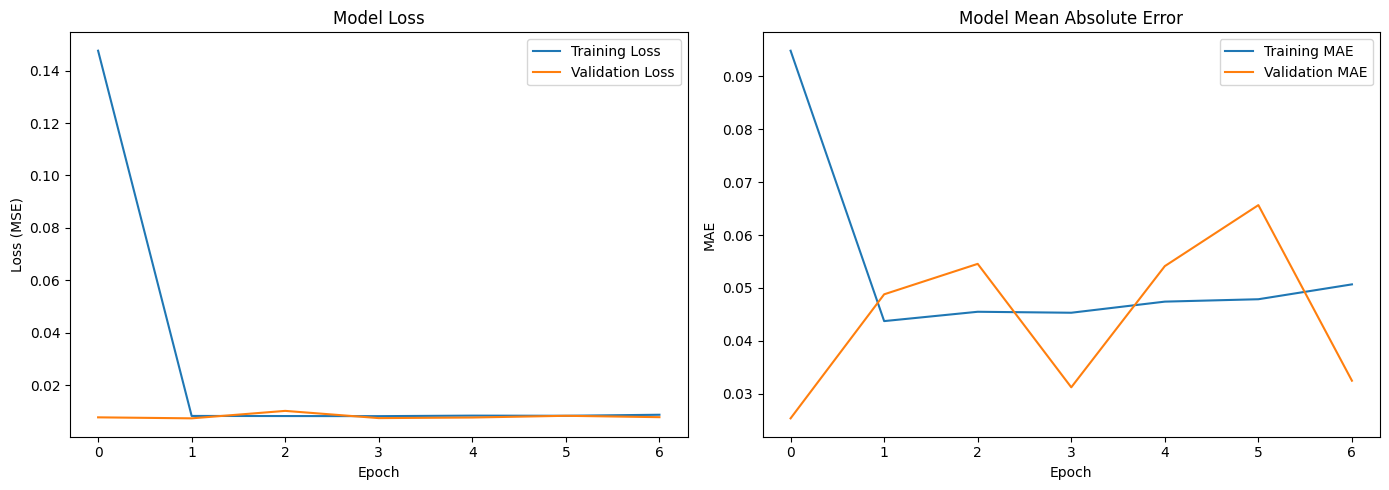

saving the model and the training history
finished
--------------------


In [30]:
# !!! Until insulation 3 houses, the models have been trained and saved !!!
# !!! insulation 28 houses, model trained and saved !!!
# !!! --- all blr_mod_lvl, absorption, insulation models trained and saved --- !!!
# !!! t_r_set 1, 3 houses trained and saved !!!
# !!! t_r_set 28 houses trained and saved
# !!! t_out 1,3 houses trained and saved
# !!! t_out 28 houses traoned and saved

for input_category in prediction_categories[4:]:
    input_categories = [input_category]
    for num_of_houses in [possible_num_of_houses[2]]:
        print("---NEW Transformer MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        transformer_model_complete(train_data, val_data, test_data, input_categories, num_of_houses)
        print("--------------------")